# Back propagation algorithm
_María Camila Vásquez Correa_

In [0]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import KFold

## Multilayer perceptron
The class model receives a list of layers (with its respective activation function) along with the loss that is going to be used for the training to initialize.
* The fit method performs the training on X and y using learning rate lr, a number of epochs epochs, a batch_size and stops given a tolerance tol.
* The evaluate method gives the prediction for an X
* The score method gives the cost function for an X and y

In [0]:
class Model:
    def __init__(self, layers, loss):
        self.layers = layers
        self.loss = loss
    
    def fit(self, X, y, lr, epochs, batch_size, tol,print_loss = True):
        if self.loss.history:
            self.initialize()
        total_loss = np.inf
        j = 0
        while j <= epochs and total_loss >= tol:
            _loss = 0
            batches = len(y)//batch_size
            for i in range(batches):
                y_pred = self.forward_pass(X[i*batch_size:(i+1)*batch_size])
                loss_ = self.loss.forward_pass(y_pred,y[i*batch_size:(i+1)*batch_size])
                loss_gradient = loss.backward_pass(y_pred, y[i*batch_size:(i+1)*batch_size])
                self.backward_pass(loss_gradient)
                self.update_parameters(lr)
                _loss += loss_
            total_loss = _loss/batches
            loss.history.append(total_loss)
            self.update_gradient_history()
            if print_loss:
                print(f'epoch {j}: loss {total_loss}') 
            j += 1
    
    def initialize(self):
        for layer in self.layers:
            if layer.trainable:
                layer.initialize()
        self.loss.initialize()
    
    def forward_pass(self, X):
        x = X.copy()
        for layer in self.layers:
            a = layer.forward_pass(x)
            x = a
        return x
    
    def backward_pass(self, upstream_gradient):
        for layer in reversed(self.layers):
            upstream_gradient = layer.backward_pass(upstream_gradient)                
        return upstream_gradient
    
    def update_parameters(self,lr):
        for layer in self.layers:
            if layer.trainable:
                layer.update_parameters(lr)
                
    def update_gradient_history(self):
        for layer in self.layers:
            if layer.trainable:
                layer.gradient_history.append([np.sum(layer.gradient_history_w),np.sum(layer.gradient_history_b)])
                layer.gradient_history_w = []
                layer.gradient_history_b = []
    
    def evaluate(self, X):
        return self.forward_pass(X)
    
    def score(self, X, y):
        y_pred = self.forward_pass(X)
        loss = self.loss.forward_pass(y_pred,y)
        return loss

### Layer
Each layer has its own initialization (in which we specify whether or not the layer is trainable) and has their forward and backward pass defined for the backpropagation algorithm

In [0]:
class Layer:
    def __init__(self):
        pass
    
    def forward_pass(self, x):
        pass
    
    def backward_pass(self, upstream_gradient):
        pass

### Local layer
Each local layer has the weights and bias for an input, and gives an output to be activated with any of the activation functions specified. It is a trainable layer, that means it has a method update_parameters in which the gradient descend algorithm is performed in each parameter (weights and bias) taking into account the local gradient stored 

In [0]:
class Local(Layer):
    def __init__(self, input_size, output_size, bias = True):
        Xstdd = 2 / (input_size + output_size)
        self.weights = np.random.normal(loc = 0, scale = Xstdd, size = (input_size, output_size))
        if bias:
            self.bias = np.zeros(output_size)
            self.has_bias = True
        else:
            self.has_bias = False
        self.local_gradient = {}
        self.x = None
        self.trainable = True
        self.gradient_history = []
        self.input_size = input_size
        self.output_size = output_size
        self.gradient_history_w = []
        self.gradient_history_b = []
    
    def initialize(self):
        Xstdd = 2 / (self.input_size + self.output_size)
        self.weights = np.random.normal(loc = 0, scale = Xstdd, size = (self.input_size, self.output_size))
        if self.has_bias:
            self.bias = np.zeros(self.output_size)
        self.local_gradient = {}
        self.gradient_history = []
        self.gradient_history_w = []
        self.gradient_history_b = []
        
    # x: (batch_size, input_size)
    # w: (input_size, output_size)
    def forward_pass(self,_x):
        self.x = _x.copy()
        return _x @ self.weights + self.bias
    
    def backward_pass(self,upstream_gradient):
        dx = upstream_gradient @ self.weights.T
        dw = self.x.T @ upstream_gradient
        if self.has_bias:
            db = np.sum(upstream_gradient, axis = 0)
            self.local_gradient = {'dw': dw, 'db': db}
            self.gradient_history_b.append(np.sum(db))
        else:
            self.local_gradient = {'dw': dw}
        self.gradient_history_w.append(np.sum(dw))
        return dx
    
    def update_parameters(self,lr):
        self.weights = self.weights - lr*self.local_gradient['dw']
        if self.has_bias:
            self.bias = self.bias - lr*self.local_gradient['db']

### Activation layers
Each activation layer has the forward and backward pass, an is not trainable. Currently available layers: Relu, Sigmoid and Hiperbolic Tangent (Tanh). For a linear activation, do not set any activation.

In [0]:
class Sigmoid(Layer):
    def __init__(self):
        self.x = None
        self.trainable = False
        
    def forward_pass(self,_x):
        self.x = _x.copy()
        return 1 / (1 + np.exp(-_x))
    
    def backward_pass(self,upstream_gradient):
        s_prime = (1 / (1 + np.exp(-self.x)))*(1-(1 / (1 + np.exp(-self.x))))
        dx = upstream_gradient * s_prime
        return dx

In [0]:
class Relu(Layer):
    def __init__(self):
        self.x = None
        self.trainable = False
        
    def forward_pass(self,x):
        self.x = x
        return np.where(x > 0, x, 0)
    
    def backward_pass(self,upstream_gradient):
        r_prime = (self.x > 0).astype(np.float32)
        dx = upstream_gradient * r_prime
        return dx

In [0]:
class Tanh(Layer):
    def __init__(self):
        self.x = None
        self.trainable = False
        
    def forward_pass(self,x):
        self.x = x
        return np.tanh(x)
    
    def backward_pass(self,upstream_gradient):
        tan = np.tanh(self.x)
        dx = 1 - np.power(tan,2)
        return dx   

### Loss layer
It receives the output of the perceptron and calculates the loss, as well as the gradient passing trough the loss function. It also stores its history, so we can explore the cost in different stages of the training.

In [0]:
class Loss:
    def __init__(self):
        self.history = []
    
    def forward_pass(self, y_pred, y_true):
        pass
    
    def backward_pass(self):
        pass
    
    def initialize(self):
        self.history = []

In [0]:
class RegressionLoss(Loss):
    def forward_pass(self, y_pred, y_true):
        a = np.sum((y_pred - y_true)**2)
        return a / len(y_true)
    
    def backward_pass(self,y_pred,y_true):
        return (1/len(y_true))*(2 * (y_pred - y_true)) 

# Preprocessing
## Data loading and normalization

In [0]:
data = pd.read_csv("examen.csv", header = None) 

In [0]:
X, y = data.loc[:,1:4].values, data.loc[:,0].values
X = X / np.max(X, axis = 0)
y = data[0] / max(data[0])
y = y.values

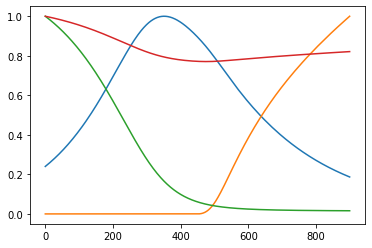

In [392]:
plt.plot(X)
plt.show()

## Data splitting
We need three sets of data: training, validation and test

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [0]:
M = X_train.shape[0] # Number of samples
m = X_train.shape[1] # Number of features or entries
n = 1 # number of outputs

In [0]:
l = 2 # Hidden layers
i = 5 # Number of neurons in each hidden layer
L = []
inp = m
activation_functions = [Sigmoid(), Sigmoid(), Sigmoid(), Sigmoid()]
for j in range(l+1):
    a = Local(inp,i)
    L.append(Local(inp,i))
    L.append(activation_functions[j])
    inp = i
L.append(Local(inp,1))

In [0]:
L[0].weights = np.array([[-0.1337,  0.0874, -0.1069, -0.2706],
        [ 0.1733,  0.3348,  0.2583,  0.1232],
        [-0.0607, -0.1557, -0.3172,  0.3525],
        [-0.2465,  0.3329, -0.0024,  0.2357],
        [ 0.4099,  0.1306, -0.1127, -0.0377]]).T

In [0]:
L[2].weights = np.array([[ 0.2459,  0.4003, -0.2752,  0.0781, -0.4327],
        [-0.2687, -0.1221, -0.0464, -0.2257, -0.2737],
        [ 0.2551, -0.1137,  0.0599, -0.1505,  0.2294],
        [-0.3911, -0.2979, -0.0358, -0.4079, -0.1854],
        [-0.1694, -0.2072, -0.3281, -0.3312,  0.3809]]).T

In [0]:
L[4].weights = np.array([[-0.3884, -0.3393, -0.0121, -0.2346,  0.2158],
        [ 0.2595, -0.1074,  0.4093,  0.3875, -0.2710],
        [ 0.2406, -0.1602, -0.3381, -0.4144,  0.2412],
        [ 0.0811, -0.1548,  0.0645, -0.2701, -0.0554],
        [ 0.1744,  0.3234,  0.1110,  0.2217, -0.0673]]).T

In [0]:
L[6].weights = np.array([[-0.2442,  0.1191,  0.3998, -0.4047,  0.4461]]).T

In [0]:
#L = [Local(4,10), Relu(), Local(10,15), Relu(), Local(15,1)]

In [0]:
loss = RegressionLoss()
model = Model(L,loss)

In [0]:
lr1 = 0.2
lr2 = 0.9

## First learning rate

In [405]:
model.fit(X_train, y_train.reshape((M,1)), 0.01, 50, M, 1e-2)

epoch 0: loss 0.14081205216507664
epoch 1: loss 0.14078885698192367
epoch 2: loss 0.14076763914757418
epoch 3: loss 0.14074822991771344
epoch 4: loss 0.14073047496038685
epoch 5: loss 0.1407142331235354
epoch 6: loss 0.1406993753081165
epoch 7: loss 0.1406857834377407
epoch 8: loss 0.14067334951653587
epoch 9: loss 0.14066197476766595
epoch 10: loss 0.1406515688455836
epoch 11: loss 0.1406420491156909
epoch 12: loss 0.14063333999562852
epoch 13: loss 0.1406253723529094
epoch 14: loss 0.1406180829540683
epoch 15: loss 0.1406114139609128
epoch 16: loss 0.14060531246984193
epoch 17: loss 0.14059973009054302
epoch 18: loss 0.14059462256069663
epoch 19: loss 0.1405899493936059
epoch 20: loss 0.14058567355593396
epoch 21: loss 0.1405817611729722
epoch 22: loss 0.14057818125908483
epoch 23: loss 0.1405749054711766
epoch 24: loss 0.14057190788321366
epoch 25: loss 0.14056916477999923
epoch 26: loss 0.1405666544685566
epoch 27: loss 0.14056435710561532
epoch 28: loss 0.14056225453982393
epoch 2

### Energy of the instant error

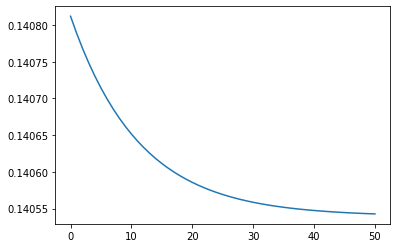

In [406]:
plt.plot(loss.history)
plt.show()

In [407]:
model.evaluate(X_train)

array([[0.40937767],
       [0.40926539],
       [0.40970973],
       [0.40988558],
       [0.40922878],
       [0.40967471],
       [0.40928887],
       [0.40998756],
       [0.41006465],
       [0.40931756],
       [0.4098471 ],
       [0.4092496 ],
       [0.40965062],
       [0.40985152],
       [0.40941179],
       [0.4093166 ],
       [0.40948955],
       [0.4093601 ],
       [0.41000794],
       [0.40972781],
       [0.40940567],
       [0.40973685],
       [0.40939024],
       [0.40967964],
       [0.40928443],
       [0.41001819],
       [0.40991623],
       [0.40996326],
       [0.40925451],
       [0.40968033],
       [0.40972043],
       [0.40921259],
       [0.40934537],
       [0.40979735],
       [0.41010957],
       [0.40969374],
       [0.40968374],
       [0.40946753],
       [0.40919171],
       [0.40976215],
       [0.40929336],
       [0.40936769],
       [0.40963314],
       [0.40959044],
       [0.40968426],
       [0.40921183],
       [0.40925866],
       [0.409

### Local gradient evolution

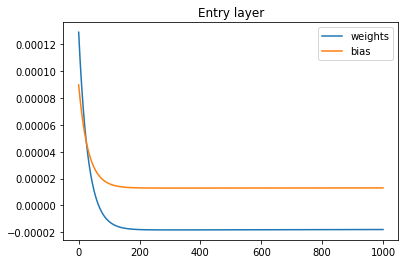

In [322]:
plt.plot(L[0].gradient_history)
plt.legend(['weights', 'bias'])
plt.title('Entry layer')
plt.show()

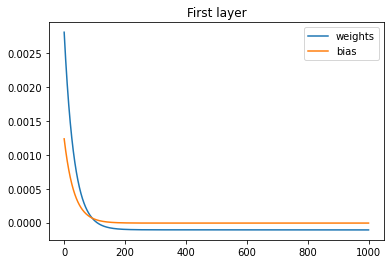

In [323]:
plt.plot(L[2].gradient_history)
plt.legend(['weights', 'bias'])
plt.title('First layer')
plt.show()

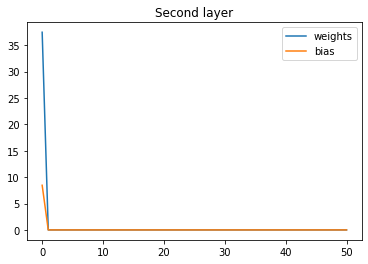

In [60]:
plt.plot(L[4].gradient_history)
plt.legend(['weights', 'bias'])
plt.title('Second layer')
plt.show()

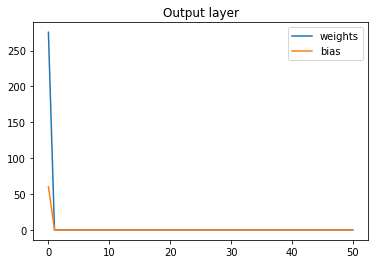

In [61]:
plt.plot(L[6].gradient_history)
plt.legend(['weights', 'bias'])
plt.title('Output layer')
plt.show()

### Predictions

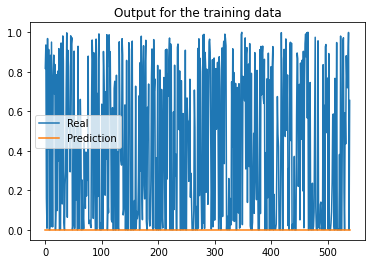

In [62]:
plt.plot(y_train, label = 'Real')
plt.plot(model.evaluate(X_train), label = 'Prediction')
plt.title('Output for the training data')
plt.legend()
plt.show()

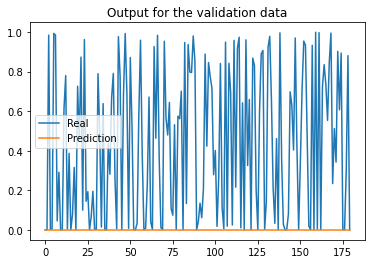

In [63]:
plt.plot(y_val, label = 'Real')
plt.plot(model.evaluate(X_val), label = 'Prediction')
plt.title('Output for the validation data')
plt.legend()
plt.show()

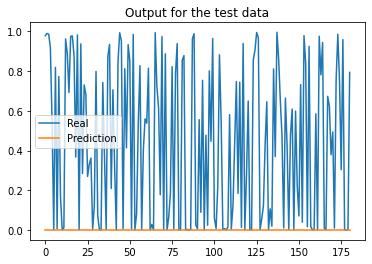

In [64]:
plt.plot(y_test, label = 'Real')
plt.plot(model.evaluate(X_test), label = 'Prediction')
plt.title('Output for the test data')
plt.legend()
plt.show()

## Cross validation

In [0]:
scores = []
cv = KFold(n_splits=10, shuffle = True, random_state = 42)
for train_index, test_index in cv.split(X_val):
    loss = RegressionLoss()
    model = Model(L,loss)
    X_train_v, X_test_v, y_train_v, y_test_v = X[train_index], X[test_index], y[train_index], y[test_index]
    model.fit(X_train_v, y_train_v.reshape((len(y_train_v),1)), lr1, 50, len(y_train_v), 1e-2, print_loss = False)
    scores.append(model.score(X_test_v, y_test_v.reshape((len(y_test_v),1))))

In [0]:
print('Cross validation score:', np.mean(scores))

Cross validation score: 0.1999999941961233


## Second learning rate

In [0]:
model.fit(X_train, y_train.reshape((M,1)), lr2, 50, M, 1e-2)

epoch 0: loss 54.57685166014407
epoch 1: loss 2.0
epoch 2: loss 2.0
epoch 3: loss 2.0
epoch 4: loss 2.0
epoch 5: loss 2.0
epoch 6: loss 2.0
epoch 7: loss 2.0
epoch 8: loss 2.0
epoch 9: loss 2.0
epoch 10: loss 2.0
epoch 11: loss 2.0
epoch 12: loss 2.0
epoch 13: loss 2.0
epoch 14: loss 2.0
epoch 15: loss 2.0
epoch 16: loss 2.0
epoch 17: loss 2.0
epoch 18: loss 2.0
epoch 19: loss 2.0
epoch 20: loss 2.0
epoch 21: loss 2.0
epoch 22: loss 2.0
epoch 23: loss 2.0
epoch 24: loss 2.0
epoch 25: loss 2.0
epoch 26: loss 2.0
epoch 27: loss 2.0
epoch 28: loss 2.0
epoch 29: loss 2.0
epoch 30: loss 2.0
epoch 31: loss 2.0
epoch 32: loss 2.0
epoch 33: loss 2.0
epoch 34: loss 2.0
epoch 35: loss 2.0
epoch 36: loss 2.0
epoch 37: loss 2.0
epoch 38: loss 2.0
epoch 39: loss 2.0
epoch 40: loss 2.0
epoch 41: loss 2.0
epoch 42: loss 2.0
epoch 43: loss 2.0
epoch 44: loss 2.0
epoch 45: loss 2.0
epoch 46: loss 2.0
epoch 47: loss 2.0
epoch 48: loss 2.0
epoch 49: loss 2.0
epoch 50: loss 2.0


### Energy of the instant error

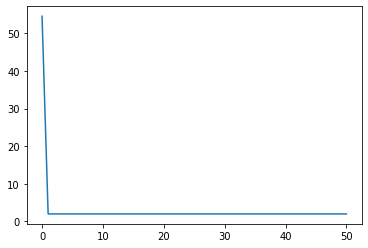

In [0]:
plt.plot(loss.history)
plt.show()

### Gradient history

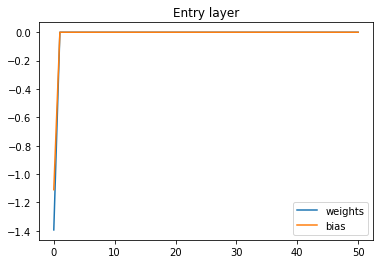

In [0]:
plt.plot(L[0].gradient_history)
plt.legend(['weights', 'bias'])
plt.title('Entry layer')
plt.show()

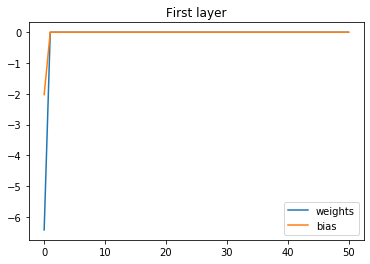

In [0]:
plt.plot(L[2].gradient_history)
plt.legend(['weights', 'bias'])
plt.title('First layer')
plt.show()

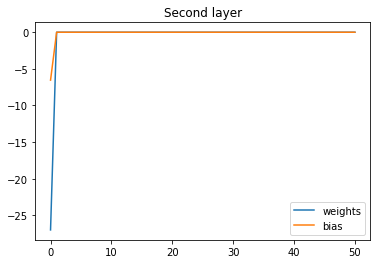

In [0]:
plt.plot(L[4].gradient_history)
plt.legend(['weights', 'bias'])
plt.title('Second layer')
plt.show()

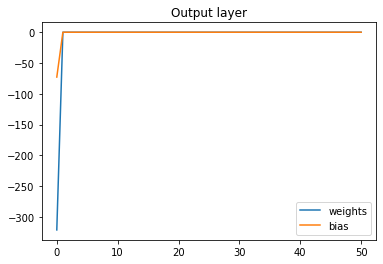

In [0]:
plt.plot(L[6].gradient_history)
plt.legend(['weights', 'bias'])
plt.title('Output layer')
plt.show()

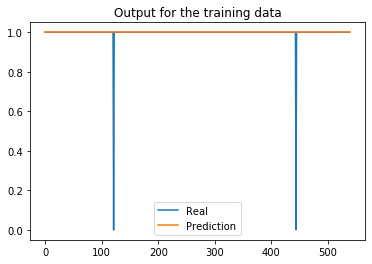

In [0]:
plt.plot(y_train, label = 'Real')
plt.plot(model.evaluate(X_train), label = 'Prediction')
plt.title('Output for the training data')
plt.legend()
plt.show()

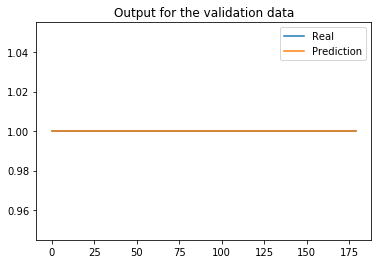

In [0]:
plt.plot(y_val, label = 'Real')
plt.plot(model.evaluate(X_val), label = 'Prediction')
plt.title('Output for the validation data')
plt.legend()
plt.show()

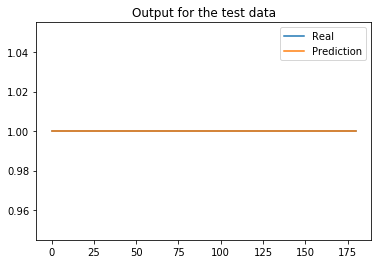

In [0]:
plt.plot(y_test, label = 'Real')
plt.plot(model.evaluate(X_test), label = 'Prediction')
plt.title('Output for the test data')
plt.legend()
plt.show()

### Cross validation

In [0]:
scores = []
cv = KFold(n_splits=10, shuffle = True, random_state = 42)
for train_index, test_index in cv.split(X_val):
    loss = RegressionLoss()
    model = Model(L,loss)
    X_train_v, X_test_v, y_train_v, y_test_v = X[train_index], X[test_index], y[train_index], y[test_index]
    model.fit(X_train_v, y_train_v.reshape((len(y_train_v),1)), lr2, 50, len(y_train_v), 1e-2, print_loss = False)
    scores.append(model.score(X_test_v, y_test_v.reshape((len(y_test_v),1))))

In [0]:
print('Cross validation score:', np.mean(scores))

Cross validation score: 0.2
